In [13]:
import csv
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class Convolution:
    # num_img_in: Number of inputs
    # filter_size: Size of kernel, will be square & less than 28
    # num_filters: Number of filters to run input against
    def __init__(self, num_img_in, filter_size, num_filters, step_size):
        self.num_img_in = num_img_in
        self.filter_size = filter_size
        self.num_filters = num_filters
        self.step_size = step_size
        
    # Given set of filters (features) #odd x #odd, iterate over input and multiply
    # img_in: a square NxM #even x #even matrix representing one of the RGB values of the input
    # features: filters/features that we compare the input against
    # step_size: fixed to 1 (does not have any effect)
    # returns a NxM matrix where each value is the result of multiplying
    # filter with the input, then dividing by the size of the filter
    # pad
    # Need to add filters to feature map
    def forward_prop_A(self, img_in, features, pad):
        N = len(img_in)
        M = len(img_in[0])
        
        # padded img as specified
        img_in = self.padding(img_in, N + 2 * pad, M + 2 * pad)

        # stride here is 1
        # out_N = (N - features_size + 2*pad_N) / stride + 1
        # out_M = (M - features_size + 2*pad_M) / stride + 1
        stride = 1
        # NxM output array (square)
        # assume the number is divisible by the stride
        out = np.zeros((len(features)
                        , (N - len(features[0]) + 2 * pad) // stride + 1
                        , (M - len(features[0][0]) + 2 * pad) // stride + 1 ))
        
        # iterate thru the input and output to corresponding part in out
        for f in range(0, self.num_filters):
            for i in range(0, len(out[0])):
                for j in range (0, len(out[0][0])):
                    # Take dot product of the flattened filter and part of input it is covering
                    out[f, i, j] = np.dot(np.ndarray.flatten(img_in[i:i+len(features[f]),
                                    j:j+len(features[f][0])]), np.ndarray.flatten(features[f]))
        return out
    
    # Add 0s to the border of orig_img as needed to achieve NxM matrix
    # assume orig_img is a square matrix with #odd x #odd
    def padding(self, orig_img, N, M):
        #print("print" ,np.shape(orig_img))
        if N - np.shape(orig_img)[0] < 0 or M - np.shape(orig_img)[1] < 0:
            raise "target NxM must be larger or equal to orig_img"
        starting_row = (N - np.shape(orig_img)[0]) // 2
        starting_column = (M - np.shape(orig_img)[1]) // 2
        pad_arr = np.zeros((N, M))
        pad_arr[starting_row:starting_row+np.shape(orig_img)[0], starting_column:starting_column+np.shape(orig_img)[1]] = orig_img
        return pad_arr

# Main Activity
## Question 1

In [21]:
data = []
with open('./img.csv') as img_file:
    csv_read = csv.reader(img_file)
    for row in csv_read:
        data.append(list(map(int, row)))

        
# plt.imshow(data, cmap='gray')
# plt.show()

## Question 2

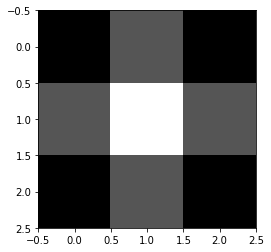

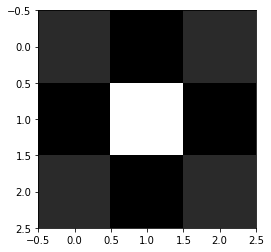

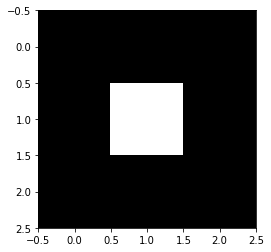

Dimension:  (3, 3)


In [23]:
kernels = []
# fun fact, this is Gaussian blur
kernel1 = 1/16*np.array([[1,2,1],[2,4,2],[1,2,1]])
kernels.append(kernel1)
plt.imshow(kernel1, cmap='gray')
plt.show()
# sharpen
kernel2 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
kernels.append(kernel2)
plt.imshow(kernel2, cmap='gray')
plt.show()
# edge detection
kernel3 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
kernels.append(kernel3)
plt.imshow(kernel3, cmap='gray')
plt.show()

# print("Number of features: ", len(kernels))
# print("Dimension: ", np.shape(kernel1))

## Question 3 & 4

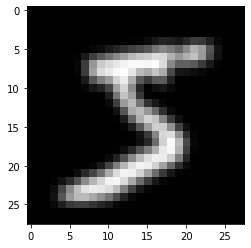

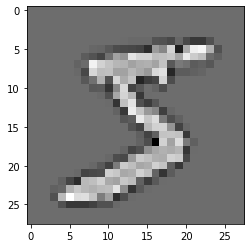

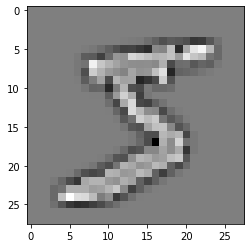

In [25]:
num_img_in = 1
filter_size = len(kernels[0])
num_filters = len(kernels)
step_size = 1

conv = Convolution(num_img_in, filter_size, num_filters, step_size)
# here we maintain the size of the feature maps
padding = (filter_size - 1) // 2
# perform kernel convolution
feature_maps = conv.forward_prop_A(data, kernels, padding)
# display the results
for fm in feature_maps:
    plt.imshow(fm, cmap='gray')
    plt.show()

## Question 5

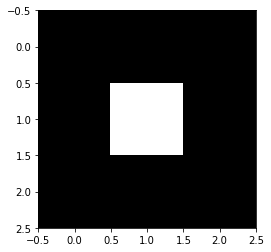

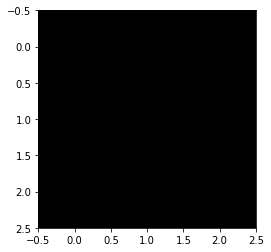

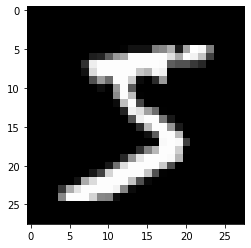

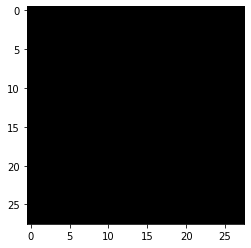

In [60]:
new_kernels = []
kernel4 = np.array([[0,0,0],[0,1,0],[0,0,0]])
new_kernels.append(kernel4)
plt.imshow(kernel4, cmap='gray')
plt.show()

kernel5 = np.zeros((3,3))
new_kernels.append(kernel5)
plt.imshow(kernel5, cmap='gray')
plt.show()

num_img_in = 1
filter_size = len(new_kernels[0])
num_filters = len(new_kernels)
step_size = 1

new_conv = Convolution(num_img_in, filter_size, num_filters, step_size)
# here we maintain the size of the feature maps
new_padding = (filter_size - 1) // 2
# perform kernel convolution
new_feature_maps = new_conv.forward_prop_A(data, new_kernels, new_padding)
# display the results
for fm in new_feature_maps:
    plt.imshow(fm, cmap='gray')
    plt.show()

In [65]:
class ReLU():
    
    def __init__(self):
        pass
        
    def forward_prop(self, img_ins):
        self.img_ins = img_ins
        for k in range(len(img_ins)):
            for i in range(0, len(self.img_ins[0])):
                for j in range(0, len(self.img_ins[0])):
                    if self.img_ins[k, i, j] < 0:
                        self.img_ins[k, i, j] = 0.0
        return self.img_ins

## Question 6

In [74]:
relu = ReLU()
feature_maps_after = relu.forward_prop(feature_maps)
print(np.argwhere((feature_maps - feature_maps_after) != 0))

[]


## Question 7

In [76]:
class Pooling:
    
    def __init__(self, pool_dim):
        # pooling dimension for this layer
        self.pool_dim = pool_dim
        
    
    # Go thru sections of the original matrix and only take the highest value
    # Put this into a new PxQ matrix
    # Pool dim is a single int representing both size of the 'pool filter' and
    # the stride. Ex: 2 -> 2x2 pooling with stride 2
    def forward_prop(self, img_in):
        # Input known at runtime, not while adding layers
        self.img_in = img_in
        # output data from pooling
        # reduce by a factor of whatever stride is
        self.out = np.zeros((len(img_in), len(img_in[0]) // self.pool_dim, len(img_in[0]) // self.pool_dim))
        # need to remember which indices provide the local max for back_prop
        self.mask = np.zeros((len(img_in), len(img_in[0]), len(img_in[0])))
        
        pool_dim = self.pool_dim
        for k in range(len(img_in)):
            # loop thru input matrix
            for i in range(0, len(self.out[0])):
                for j in range(0, len(self.out[0])):
                    # get largest value in pool
                    vert = i * pool_dim
                    horiz = j * pool_dim
                    pool = self.img_in[k, vert:vert+pool_dim, horiz:horiz+pool_dim]
                    #print(pool)
                    self.out[k, i,j] = np.amax(pool)
                    max_idx = np.argmax(pool)
                    # flag local max indices
                    self.mask[k, vert + max_idx // pool_dim, horiz + max_idx % pool_dim] = 1.0
              
        return self.out, self.mask
    
    def padding(self, orig_img, N, M):
        starting_row = int((N - np.shape(orig_img)[0]) // 2)
        starting_column = int((M - np.shape(orig_img)[1]) // 2)
        pad_arr = np.zeros((N, M))
        pad_arr[starting_row:starting_row+np.shape(orig_img)[0], starting_column:starting_column+np.shape(orig_img)[1]] = orig_img
        return pad_arr

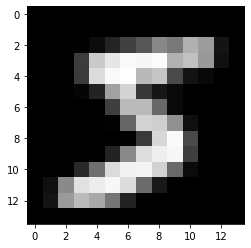

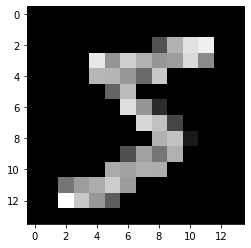

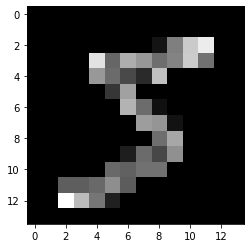

In [78]:
pooling_dim = 2
pool = Pooling(pooling_dim)

pooling_res, pooling_mask = pool.forward_prop(feature_maps_after)
for pr in pooling_res:
    plt.imshow(pr, cmap='gray')
    plt.show()

## Question 8

In [95]:
class FullyConnected:

    def __init__(self, num_inputs, num_outputs, learning_rate):
        self.weights = 0.01*np.random.rand(num_inputs, num_outputs)
        self.bias = np.zeros((num_outputs, 1))
        self.lr = learning_rate

    def forward_prop(self, inputs):
        self.inputs = inputs
        return np.dot(self.inputs, self.weights) + self.bias.T

In [96]:
# flatten our data to be fed into a fully connected layer
print(np.shape(pooling_res))
pooling_res_flat = np.ndarray.flatten(pooling_res)
print(np.shape(pooling_res_flat))

# first fully connected output 256 values
fc1 = FullyConnected(len(pooling_res_flat), 256, 0.01)
fc1_output = fc1.forward_prop(pooling_res_flat)
fc2 = FullyConnected(256, 10, 0.01)
fc2_output = fc2.forward_prop(fc1_output)
print(fc2_output)

(3, 14, 14)
(588,)
[[368.30365102 364.63224303 352.15504399 381.01460085 361.89387092
  373.69536831 338.54699213 341.84204447 333.42111413 347.13485252]]


## Question 9

In [97]:
class Softmax:
    def __init__(self):
        pass
    def forward_prop(self, inputs):
        exp = np.exp(inputs, dtype=np.float)
        self.out = exp/np.sum(exp)
        return self.out

In [98]:
sm = Softmax()
print(np.around(sm.forward_prop(fc2_output),3))

[[0.    0.    0.    0.999 0.    0.001 0.    0.    0.    0.   ]]
